In [10]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dft = pd.read_csv('dataset/top12-no-outliers.csv') # base top12 - test set
dfn = pd.read_csv('dataset/noisy.csv') # noisy padding
dfv = pd.read_csv('dataset/vae.csv') # vae samples
dfa = pd.concat([dfn, dfv])

In [3]:
print(f"len(dft): {len(dft)} | len(dfn): {len(dfn)} | len(dfc): {len(dfv)}")

len(dft): 51 | len(dfn): 49 | len(dfc): 900


In [4]:
Xv, yv = dfv.drop(['y'], axis=1), dfv['y']
Xt, yt = dft.drop(['y'], axis=1), dft['y']

In [15]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    print(f"Accuracy: {accuracy:.3f} | AUC: {roc_auc:.3f}")
    print(f"Sensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}")
    print(f"PPV: {ppv:.3f} | NPV: {npv:.3f}")
    return {
        'accuracy': accuracy,
        'auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'optimal_idx': optimal_idx,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
    }

# simple xgboost on vae

In [33]:
model = XGBClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(Xv, yv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best neglog:", best_score)

# Use best model for predictions
model = grid_search.best_estimator_
yhat = model.predict(Xt)
yhat_proba = model.predict_proba(Xt)[:, 1]

# Evaluate model
metrics = evaluate_model(yt, yhat, yhat_proba)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best neglog: -0.009047484749097685
Accuracy: 0.961 | AUC: 0.993
Sensitivity: 0.970 | Specificity: 0.944
PPV: 0.943 | NPV: 1.000


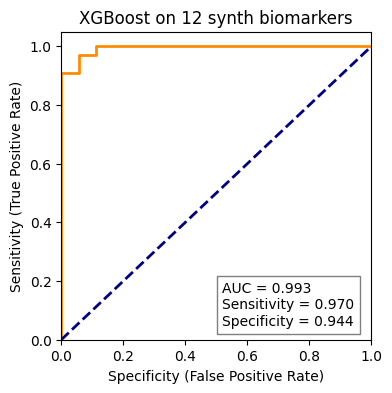

In [34]:
# Plotting
fpr = metrics['fpr']
tpr = metrics['tpr']
roc_auc = metrics['auc']
sensitivity = metrics['sensitivity']
specificity = metrics['specificity']
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('XGBoost on 12 synth biomarkers')
#plt.legend(loc="lower right")

# Add custom text box
plt.text(0.52, 0.05, 'AUC = %0.3f\nSensitivity = %0.3f\nSpecificity = %0.3f' % (roc_auc, sensitivity, specificity),
         bbox=dict(facecolor='white', alpha=0.5))

# save fig as pdf 
plt.savefig('roc-top12-xgboost-vae.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# explain the variables with SHAP

In [19]:
model = grid_search.best_estimator_
importances = model.feature_importances_
feature_importance = sorted(zip(importances, Xv.columns), reverse=True)
for importance, feature in feature_importance:
    print(f"{feature}: {importance}")

x9: 0.16967135667800903
x2: 0.16302049160003662
x10: 0.14878512918949127
x1: 0.10011464357376099
x12: 0.07415478676557541
x6: 0.05694553256034851
x11: 0.05518687516450882
x7: 0.05103380233049393
x5: 0.0483788400888443
x4: 0.04835554584860802
x8: 0.043165963143110275
x3: 0.04118698462843895


In [20]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)
mean_shap = np.abs(shap_values).mean(axis=0)
base_value = explainer.expected_value
equation = f"y = {base_value:.4f}"
for i, col in enumerate(Xv.columns):
    equation += f" + {mean_shap[i]:.4f} * {col}"
print("Approximate equation:")
print(equation)

Approximate equation:
y = 0.0409 + 0.9070 * x1 + 1.5330 * x2 + 0.3056 * x3 + 0.4342 * x4 + 0.3710 * x5 + 0.2661 * x6 + 0.3811 * x7 + 0.2945 * x8 + 1.4589 * x9 + 1.0202 * x10 + 0.5447 * x11 + 0.9328 * x12


# easy ridge regression

In [35]:
model = RidgeClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(-10, 1, num=25)  # 25 values from 1e-6 to 1e6
param_grid = {
    'alpha': alphas,
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xv, yv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best accuracy:", best_score)

# Use best model for predictions
best_model = grid_search.best_estimator_

# Calibrate the classifier to get probability estimates
calibrated_model = CalibratedClassifierCV(best_model, cv='prefit')
calibrated_model.fit(Xv, yv)

yhat = calibrated_model.predict(Xt)
yhat_score = calibrated_model.predict_proba(Xt)[:, 1]

# Evaluate model
metrics  = evaluate_model(yt, yhat, yhat_score)

Best Parameters: {'alpha': np.float64(1e-10), 'fit_intercept': True, 'solver': 'lsqr'}
Best accuracy: 0.8356
Accuracy: 0.725 | AUC: 0.842
Sensitivity: 0.909 | Specificity: 0.722
PPV: 0.880 | NPV: 0.577


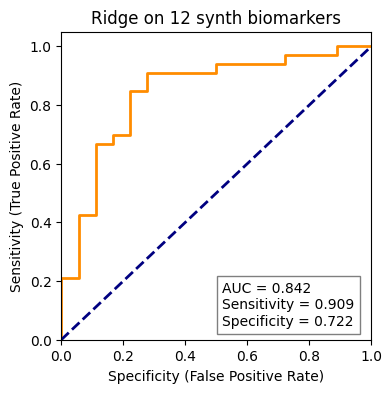

In [36]:
# Plotting
fpr = metrics['fpr']
tpr = metrics['tpr']
roc_auc = metrics['auc']
sensitivity = metrics['sensitivity']
specificity = metrics['specificity']
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Ridge on 12 synth biomarkers')
#plt.legend(loc="lower right")

# Add custom text box
plt.text(0.52, 0.05, 'AUC = %0.3f\nSensitivity = %0.3f\nSpecificity = %0.3f' % (roc_auc, sensitivity, specificity),
         bbox=dict(facecolor='white', alpha=0.5))

# save fig as pdf 
plt.savefig('roc-top12-ridge-vae.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()